## Settings 

Upgrade tqdm:

In [0]:
!pip install --upgrade tqdm

Requirement already up-to-date: tqdm in /usr/local/lib/python3.6/dist-packages (4.45.0)


Restart the Python kernel to load the updated version:

In [0]:
import os 
os.kill(os.getpid(), 9)

TF version


In [0]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


### Clone the Github repo


In [0]:
!rm -rf sample_data
!rm -rf stylegan-encoder

!git clone https://github.com/Azmarie/stylegan-encoder.git

Cloning into 'stylegan-encoder'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 486 (delta 0), reused 0 (delta 0), pack-reused 483
Receiving objects: 100% (486/486), 12.79 MiB | 2.67 MiB/s, done.
Resolving deltas: 100% (266/266), done.


In [0]:
cd stylegan-encoder

/content/stylegan-encoder


In [0]:
ls

adaptive.py                            Play_with_latent_directions.ipynb
align_images.py                        pretrained_example.py*
config.py*                             README.md*
dataset_tool.py*                       requirements.txt
dnnlib/                                robust_loss/
encode_images.py                       run_metrics.py*
encoder/                               StyleGAN_Encoder_Tutorial.ipynb
ffhq_dataset/                          swa.py
generate_figures.py*                   teaser.png
Learn_direction_in_latent_space.ipynb  train_effnet.py
LICENSE.txt*                           training/
metrics/                               train.py*
mona_example.jpg                       train_resnet.py


### Set up folder structure for our images

In [0]:
rm -rf aligned_images raw_images

In [0]:
mkdir aligned_images raw_images

# I. Get Images:

### Upload Images manually

### Take images using webcam

In [0]:
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import io
from PIL import Image
from datetime import datetime

VIDEO_HTML = """
<video autoplay
 width=%d height=%d style='cursor: pointer;'></video>
<script>

var video = document.querySelector('video')

navigator.mediaDevices.getUserMedia({ video: true })
  .then(stream=> video.srcObject = stream)
  
var data = new Promise(resolve=>{
  video.onclick = ()=>{
    var canvas = document.createElement('canvas')
    var [w,h] = [video.offsetWidth, video.offsetHeight]
    canvas.width = w
    canvas.height = h
    canvas.getContext('2d')
          .drawImage(video, 0, 0, w, h)
    video.srcObject.getVideoTracks()[0].stop()
    video.replaceWith(canvas)
    resolve(canvas.toDataURL('image/jpeg', %f))
  }
})
</script>
"""

def take_photo(quality=1.0, size=(800,600)):
  display(HTML(VIDEO_HTML % (size[0],size[1],quality)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  f = io.BytesIO(binary)
  img = np.asarray(Image.open(f))
  
  timestampStr = datetime.now().strftime("%d-%b-%Y (%H:%M:%S.%f)")
  filename = 'raw_images/photo_%s.jpeg' %timestampStr
  Image.fromarray(img).save(filename)
  print('Image captured and saved to %s' %filename)

In [0]:
img = take_photo() # click the image to capture a frame!

Image captured and saved to raw_images/photo_19-Mar-2020 (23:12:00.774122).jpeg


### Check the contents of our image folder before we start:

In [0]:
rm -r raw_images/.ipynb_checkpoints

Found 6 images in raw_images
['bradpitt.png', 'edawrd.png', 'george.jpg', 'ld1.png', 'ld2.png', 'natalie-portman.jpg']


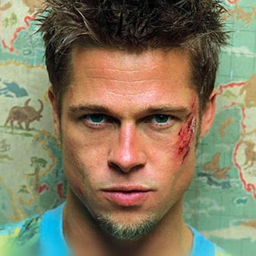

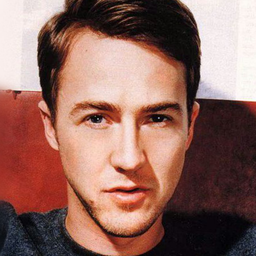

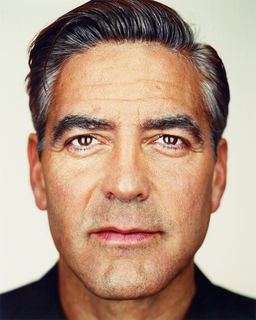

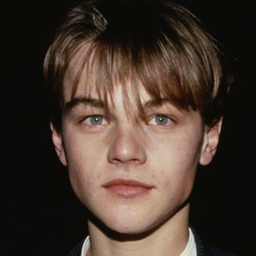

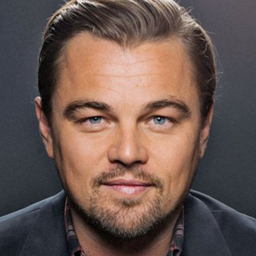

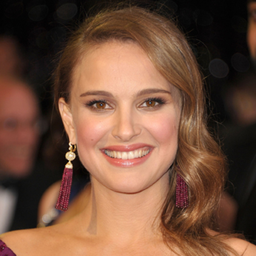

In [0]:
from PIL import Image
import os
imgs = sorted(os.listdir('raw_images'))

print("Found %d images in %s" %(len(imgs), 'raw_images'))
if len(imgs) == 0:
  print("Upload images to the \"raw_images\" folder!")
else:
  print(imgs)

for img_path in imgs:
  img = Image.open('raw_images/' + img_path)
  
  w,h = img.size
  rescale_ratio = 256 / min(w,h)
  img = img.resize((int(rescale_ratio*w),int(rescale_ratio*h)), Image.LANCZOS)
  display(img)

# II. Auto-Align faces:
### This script wil:


1.   Look for faces in the images
2.   Crop out the faces from the images
3.   Align the faces (center the nose and make the eyes horizontal)
4.   Rescale the resulting images and save them in "aligned_images" folder


In [0]:
!python align_images.py raw_images/ aligned_images/ --output_size=1024

Using TensorFlow backend.
Aligning george.jpg ...
Getting landmarks...
Starting face alignment...
Wrote result aligned_images/george_01.png
Aligning edawrd.png ...
Getting landmarks...
Starting face alignment...
Wrote result aligned_images/edawrd_01.png
Aligning ld1.png ...
Getting landmarks...
Starting face alignment...
Wrote result aligned_images/ld1_01.png
Aligning natalie-portman.jpg ...
Getting landmarks...
Starting face alignment...
Wrote result aligned_images/natalie-portman_01.png
Aligning bradpitt.png ...
Getting landmarks...
Starting face alignment...
Wrote result aligned_images/bradpitt_01.png
Aligning Scarlett_Johansson.png ...
Getting landmarks...
Starting face alignment...
Wrote result aligned_images/Scarlett_Johansson_01.png
Starting face alignment...
Wrote result aligned_images/Scarlett_Johansson_02.png
Aligning ld2.png ...
Getting landmarks...
Starting face alignment...
Wrote result aligned_images/ld2_01.png


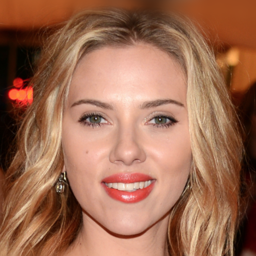

'img 1: Scarlett_Johansson_01.png'

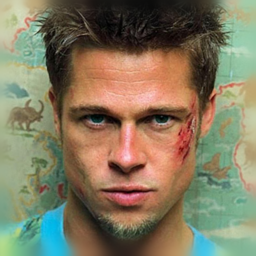

'img 2: bradpitt_01.png'

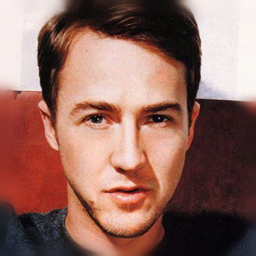

'img 3: edawrd_01.png'

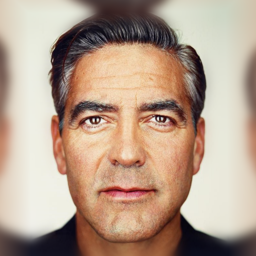

'img 4: george_01.png'

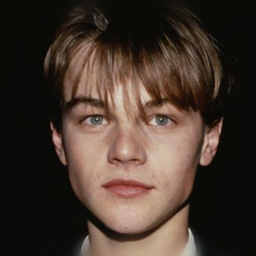

'img 5: ld1_01.png'

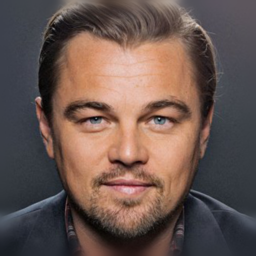

'img 6: ld2_01.png'

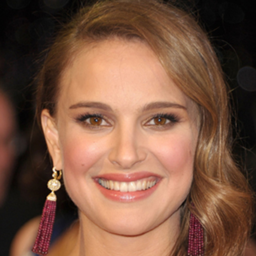

'img 7: natalie-portman_01.png'

In [0]:
def display_folder_content(folder, res = 256):
  if folder[-1] != '/': folder += '/'
  for i, img_path in enumerate(sorted(os.listdir(folder))):
    if '.png' in img_path:
      display(Image.open(folder+img_path).resize((res,res)), 'img %d: %s' %(i, img_path))
      print('\n')
      
display_folder_content('aligned_images')

# Encoding faces into StyleGAN latent space:

### Download a pretrained resnet encoder

In [0]:
!gdown https://drive.google.com/uc?id=1aT59NFy9-bNyXjDuZOTMl0qX0jmZc6Zb
!mkdir data
!mv finetuned_resnet.h5 data
!rm -rf generated_images latent_representations

Downloading...
From: https://drive.google.com/uc?id=1aT59NFy9-bNyXjDuZOTMl0qX0jmZc6Zb
To: /content/stylegan-encoder/finetuned_resnet.h5
330MB [00:02, 142MB/s]



> #### Extra encoding options: https://github.com/pbaylies/stylegan-encoder/blob/master/encode_images.py
The pretrained StyleGAN network from NVIDIA trained on faces and a pretrained VGG-16 network, trained on ImageNet will be downloaded

#### After guessing the initial latent codes using the pretrained ResNet, it will run gradient descent to optimize the latent faces!
#### by default, we're optimizing w vectors, not z-vectors!


In [0]:
import os
print("aligned_images contains %d images ready for encoding!" %len(os.listdir('aligned_images/')))
print("Recommended batch_size for the encode_images process: %d" %min(len(os.listdir('aligned_images/')), 8))

aligned_images contains 4 images ready for encoding!
Recommended batch_size for the encode_images process: 4


## Fast version:

In [0]:
!python encode_images.py --optimizer=lbfgs --face_mask=False --iterations=50 --use_lpips_loss=0 --use_discriminator_loss=0 --output_video=True aligned_images/ generated_images/ latent_representations/
print("\n************ Latent code optimization finished! ***************")




Using TensorFlow backend.










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




Instructions for updating:
If using Keras pass *_constraint arguments to layers.

58892288/58889256 [==============================] - 7s 0us/step
  0% 0/4 [00:00<?, ?it/s]WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:431: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.


Loading ResNet Model:

  0% 0/50 [00:00<?, ?it/s]WARNING:tensorflow:
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This op will be r

In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=9492741fdac5e76a4593887aa118773b61e672e813325b6f2e07f8540082c253
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.6 GB  | Proc size: 458.6 MB
GPU RAM Free: 11372MB | Used: 69MB | Util   1% | Total 11441MB


In [0]:
!kill -9 -1

## Slow version:

In [0]:
!python encode_images.py --optimizer=adam --lr=0.02 --decay_rate=0.95 --decay_steps=6 --use_l1_penalty=0.3 --face_mask=True --iterations=400 --early_stopping=True --early_stopping_threshold=0.05 --average_best_loss=0.5 --use_lpips_loss=0 --use_discriminator_loss=0 --output_video=True aligned_images/ generated_images/ latent_representations/
print("\n************ Latent code optimization finished! ***************")




Using TensorFlow backend.



2020-03-20 17:19:14.834612: W tensorflow/compiler/xla/service/platform_util.cc:256] unable to create StreamExecutor for CUDA:0: failed initializing StreamExecutor for CUDA device ordinal 0: Internal: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_OUT_OF_MEMORY: out of memory; total memory reported: 7981694976
2020-03-20 17:19:14.834868: F tensorflow/stream_executor/lib/statusor.cc:34] Attempting to fetch value instead of handling error Internal: no supported devices found for platform CUDA

************ Latent code optimization finished! ***************


## Showtime!
### Let's load the StyleGAN network into memory:

In [0]:
import os
import dnnlib, pickle
import dnnlib.tflib as tflib
tflib.init_tf()
synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True), minibatch_size=1)

model_dir = 'cache/'
model_path = [model_dir+f for f in os.listdir(model_dir) if 'stylegan-ffhq' in f][0]
print("Loading StyleGAN model from %s..." %model_path)

with dnnlib.util.open_url(model_path) as f:
  generator_network, discriminator_network, averaged_generator_network = pickle.load(f)
  
print("StyleGAN loaded & ready for sampling!")

Loading StyleGAN model from cache/d24503cf292c091a2e8d9673172621a8_karras2019stylegan-ffhq-1024x1024.pkl...







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
StyleGAN loaded & ready for sampling!


In [0]:
def generate_images(generator, latent_vector, z = True):
    batch_size = latent_vector.shape[0]
    
    if z: #Start from z: run the full generator network
        return generator.run(latent_vector.reshape((batch_size, 512)), None, randomize_noise=False, **synthesis_kwargs)
    else: #Start from w: skip the mapping network
        return generator.components.synthesis.run(latent_vector.reshape((batch_size, 18, 512)), randomize_noise=False, **synthesis_kwargs)

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
def plot_imgs(model, rows, columns):
  for i in range(rows):
    f, axarr = plt.subplots(1,columns, figsize = (20,8))
    for j in range(columns):
      img = generate_images(model, np.random.randn(1,512), z = True)[0]
      axarr[j].imshow(img)
      axarr[j].axis('off')
      axarr[j].set_title('Resolution: %s' %str(img.shape))
    plt.show()

## Let's plot some random StyleGAN samples:

In [0]:
plot_imgs(averaged_generator_network, 3, 3)

# Let's take a look at the results of our encoding:
### If the results don't look great: Play with the encoding arguments!!!
> 1. Run the optimization for more iterations (eg 500)
> 2. Decrease the L1 penalty (to eg 0.15)
> 3. Try a lower initial learning rate (eg 0.02) or play with the decay_rate
> 4. Find out about the other encoding options here: https://github.com/pbaylies/stylegan-encoder/blob/master/encode_images.py
> 5. You can find a bunch of good presets on the repo documentation: https://github.com/pbaylies/stylegan-encoder

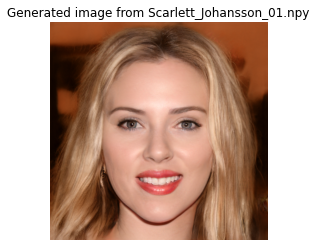

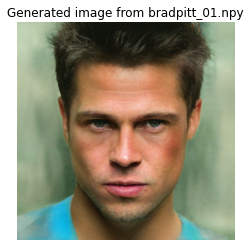

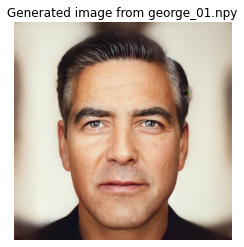

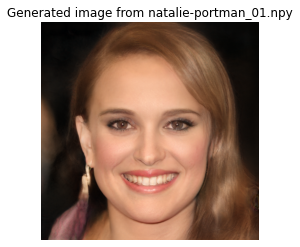

In [0]:
import numpy as np

for f in sorted(os.listdir('latent_representations')):
  w = np.load('latent_representations/' + f).reshape((1,18,-1))
  img = generate_images(averaged_generator_network, w, z = False)[0]
  plt.imshow(img)
  plt.axis('off')
  plt.title("Generated image from %s" %f)
  plt.show()

## Let's compare our encoded samples with the original ones:

**Note: when you optimized with the setting --face_mask=True, the hair will be copied from the source images. If you don't want this, optimize without that setting!**

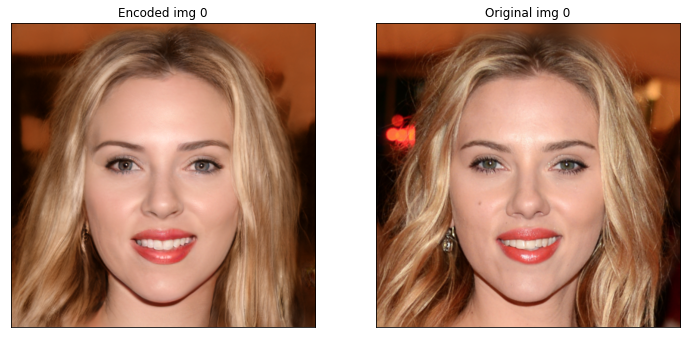

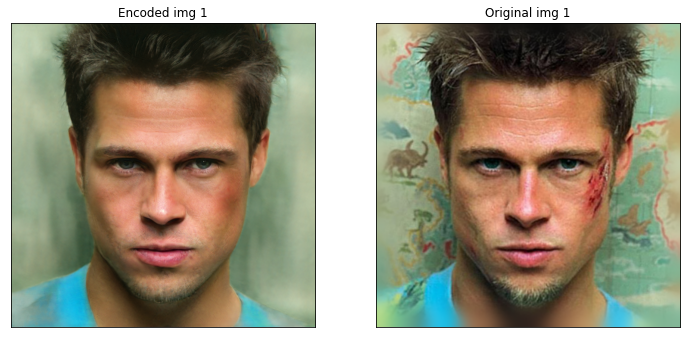

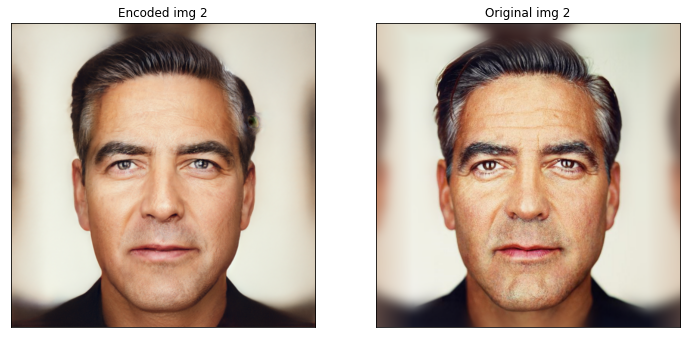

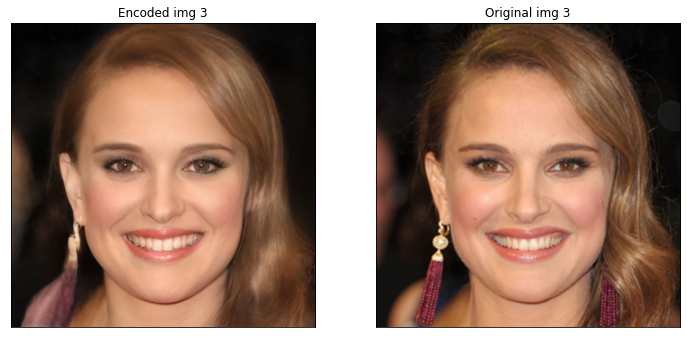

In [0]:
import matplotlib.pyplot as plt
from PIL import Image

def plot_two_images(img1,img2, img_id, fs = 12):
  f, axarr = plt.subplots(1,2, figsize=(fs,fs))
  axarr[0].imshow(img1)
  axarr[0].title.set_text('Encoded img %d' %img_id)
  axarr[1].imshow(img2)
  axarr[1].title.set_text('Original img %d' %img_id)
  plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
  plt.show()

def display_sbs(folder1, folder2, res = 256):
  if folder1[-1] != '/': folder1 += '/'
  if folder2[-1] != '/': folder2 += '/'
    
  imgs1 = sorted([f for f in os.listdir(folder1) if '.png' in f])
  imgs2 = sorted([f for f in os.listdir(folder2) if '.png' in f])
  if len(imgs1)!=len(imgs2):
    print("Found different amount of images in aligned vs raw image directories. That's not supposed to happen...")
  
  for i in range(len(imgs1)):
    img1 = Image.open(folder1+imgs1[i]).resize((res,res))
    img2 = Image.open(folder2+imgs2[i]).resize((res,res))
    plot_two_images(img1,img2, i)
    print("")
     
display_sbs('generated_images/', 'aligned_images/', res = 512)

### Note: 
If you want to watch the whole thing unfold for yourself, you can **download the optimization videos** from the "videos" folder

# IV. Cherry pick images & dump their latent vectors to disk
### Manipulating latent vectors (Notebook II) is tricky and will only work well if the face encoding looks 'good'
### Cherry pick a few images where the optimization worked well
> (Use the image indices from the plot titles above)

In [0]:
good_images = [0,1,2,3]  #Change these numbers to pick out latents that worked well (see the image plots)

## Save these latent vectors to disk:

In [0]:
import numpy as np
latents = sorted(os.listdir('latent_representations'))

out_file = '/content/output_vectors.npy'

final_w_vectors = []
for img_id in good_images:
  w = np.load('latent_representations/' + latents[img_id])
  final_w_vectors.append(w)

final_w_vectors = np.array(final_w_vectors)
np.save(out_file, final_w_vectors)
print("%d latent vectors of shape %s saved to %s!" %(len(good_images), str(w.shape), out_file))

4 latent vectors of shape (18, 512) saved to /content/output_vectors.npy!


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!cp /content/output_vectors.npy '/content/gdrive/My Drive/'

## Colab Clean Cache
